# Исследование объявлений о продаже квартир

В нашем распоряжении архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. 
По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

**Цель:** определить рыночную стоимость объектов недвижимости, установить параметры квартиры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

**План работы:**
- посмотреть на параметры объектов
- изучить, как быстро продавались квартиры
- исследовать, какие факторы больше всего влияли на стоимость объектов
- сравнить стоимость квадратного метра в разных населенных пунктах
- посмотреть, как зависит стоимость от расстояния до центра

### Откроем файл с данными и изучим общую информацию. 

In [1]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

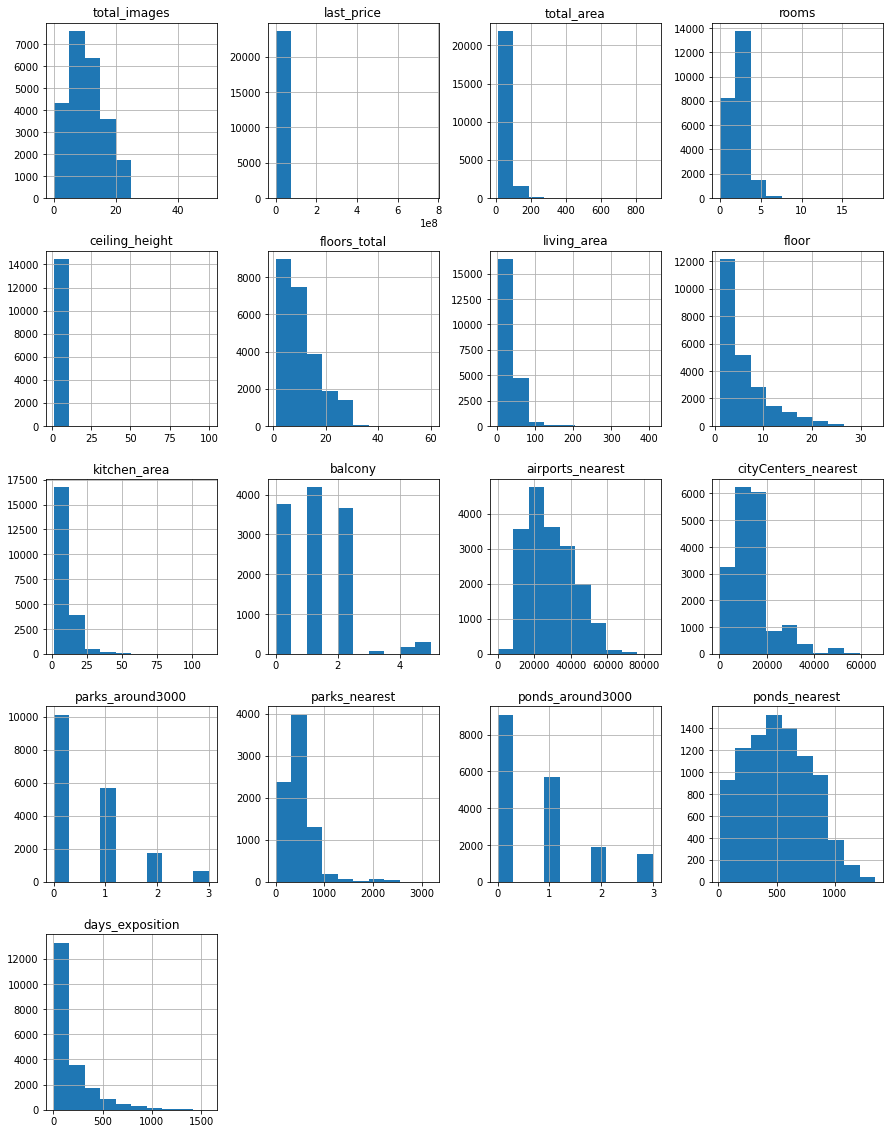

In [3]:
data.hist(figsize=(15, 20));

### Предобработка данных

In [4]:
# подсчитаем количество пропущенных значений для каждого столбца
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропущенные значения в столбце `ceiling_height` можем заменить средним значением этого показателя.

Скорее всего, пропуски в этом столбце обусловлены человеческим фактором (продавцы не заполнили поле).

In [5]:
# посмотрим на уникальные значения столбца ceiling_height
data.ceiling_height.unique()

array([  2.7 ,    nan,   3.03,   2.5 ,   2.67,   2.56,   3.05,   2.75,
         2.6 ,   2.9 ,   2.8 ,   2.55,   3.  ,   2.65,   3.2 ,   2.61,
         3.25,   3.45,   2.77,   2.85,   2.64,   2.57,   4.15,   3.5 ,
         3.3 ,   2.71,   4.  ,   2.47,   2.73,   2.84,   3.1 ,   2.34,
         3.4 ,   3.06,   2.72,   2.54,   2.51,   2.78,   2.76,  25.  ,
         2.58,   3.7 ,   2.52,   5.2 ,   2.87,   2.66,   2.59,   2.  ,
         2.45,   3.6 ,   2.92,   3.11,   3.13,   3.8 ,   3.15,   3.55,
         3.16,   3.62,   3.12,   2.53,   2.74,   2.96,   2.46,   5.3 ,
         5.  ,   2.79,   2.95,   4.06,   2.94,   3.82,   3.54,   3.53,
         2.83,   4.7 ,   2.4 ,   3.38,   3.01,   5.6 ,   3.65,   3.9 ,
         3.18,   3.35,   2.3 ,   3.57,   2.48,   2.62,   2.82,   3.98,
         2.63,   3.83,   3.52,   3.95,   3.75,   2.88,   3.67,   3.87,
         3.66,   3.85,   3.86,   4.19,   3.24,   4.8 ,   4.5 ,   4.2 ,
         3.36,  32.  ,   3.08,   3.68,   3.07,   3.37,   3.09,   8.  ,
      

In [6]:
# так как присутсвуют несколько выбросов, которые могут повлиять на среднее, возьмем медианное значение высоты потолка
# проверим, не осталось ли пропусков
data['ceiling_height'] = data['ceiling_height'].fillna(value=(data['ceiling_height'].median()))
data['ceiling_height'].isna().sum()

0

Пропущенные значения в столбце `floors_total` можем заменить на значение столбца `floor` + 2, так как обычно спрос выше на квартиры не на первом и не на последнем этаже. 

В данных пропущено всего 86 значений, замена пропусков приблизительным значением не будет сильно искажать общую статистику.

In [7]:
data.loc[(data['floors_total'].isna(), 'floors_total')] = data['floor'] + 2

In [8]:
# проверим, не осталось ли пропусков
data['floors_total'].isna().sum()

0

На данные в столбце `living_area` сильнее всего влияет количество комнат в квартире. Заполнить пропуски в этом столбце можем медианным значением для группы (по количеству комнат из столбца `rooms`).

Пропуски в этом столбце также можно объяснить человеческим фактором (оставили поле пустым).

In [9]:
for value in data['rooms'].unique():
    data.loc[(data['rooms'] == value) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == value), 'living_area'].median()

In [10]:
# проверим, не осталось ли пропусков
data['living_area'].isna().sum()

0

Пропуски в столбце `is_apartment` можем заменить на значение False. 

Некоторые продавцы могли подумать, что заполнять это поле нужно только если квартира является апартаментами.

In [11]:
data.loc[(data['is_apartment'].isna(), 'is_apartment')] = False

In [12]:
# проверим, не осталось ли пропусков
data['is_apartment'].isna().sum()

0

На данные в столбце `kitchen_area` также влияет количество комнат в квартире. Для начала обратим внимание на студии. Возможно площадь кухни не указана для таких квартир. Там это значение можно заменить на 0, потому что в студиях кухня входит в жилую площадь. Скорее всего, продавцы именно поэтому не заполнили поле площадь кухни.

Тоже самое справедливо и для квартир со свободной планировкой.

In [13]:
# посмотрим есть ли студии, где площадь кухни указана
data.query('studio == True and not kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [14]:
# заменим для всех студий площадь кухни на 0
data.loc[(data['studio'] == True) & (data['kitchen_area'].isna()), 'kitchen_area'] = 0

In [15]:
# посмотрим есть ли открытые планировки, где площадь кухни указана
data.query('open_plan == True and not kitchen_area.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [16]:
# заменим для всех открытых планировок площадь кухни на 0
data.loc[(data['open_plan'] == True) & (data['kitchen_area'].isna()), 'kitchen_area'] = 0

In [17]:
# проверим, сколько осталось пропусков
data['kitchen_area'].isna().sum()

2062

In [18]:
# проверим, есть ли в данных квартиры с количеством комнат 0, но не студии и не свободные планировки
data.query('rooms == 0 and studio == False and open_plan == False')['rooms'].count()

0

Для остальных пропущенных значений столбца `kitchen_area` мы можем заполнить пропуски медианным значением для групп (по количеству комнат из столбца `rooms`).

Пропуски в этом столбце также можно объяснить человеческим фактором (оставили поле пустым, пропустили по невнимательности, не знали значение).

In [19]:
for value in data['rooms'].unique():
    data.loc[(data['rooms'] == value) & (data['kitchen_area'].isna()) & (data['studio'] == False), 'kitchen_area'] = \
    data.loc[(data['rooms'] == value), 'kitchen_area'].median()

In [20]:
# проверим, не осталось ли пропусков
data['kitchen_area'].isna().sum()

0

Пропуски в столбце `balcony` можем заменить на 0. 

Скорее всего, если продавец не указал число балконов, то в его квартире их нет.

In [21]:
data.loc[(data['balcony'].isna(), 'balcony')] = 0

In [22]:
# проверим, не осталось ли пропусков
data['balcony'].isna().sum()

0

Пропуски в столбце `locality_name` можем заменить на "Ленинградская область", так как точной логической замены мы не знаем, а причиной также скорее всего является человеческий фактор. 

В данном случае мы имеем всего 49 пропущенных значений, что не должно исказить общую статистику.

In [23]:
data.loc[(data['locality_name'].isna(), 'locality_name')] = 'Ленинградская область'

In [24]:
# проверим, не осталось ли пропусков
data['locality_name'].isna().sum()

0

Пропуски также имеются в столбцах, содержащих информацию о расстояниях `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest`, которые должны заполняться автоматически системой. Возможно это связано с конкретными населенными пунктами.

In [25]:
# сгруппируем данные по населенному пункту и посмотрим на пропуски
data.groupby('locality_name') \
    [['locality_name', 'airports_nearest', 'cityCenters_nearest', 'parks_nearest', 'ponds_nearest']].count() \
    .sort_values(by='cityCenters_nearest', ascending=False)

,locality_name,airports_nearest,cityCenters_nearest,parks_nearest,ponds_nearest
locality_name,,,,,
Санкт-Петербург,15721,15636,15660,7284,7983
посёлок Шушары,440,436,436,0,152
Пушкин,369,369,368,212,177
Колпино,338,337,337,133,190
посёлок Парголово,327,327,327,10,56
...,...,...,...,...,...
деревня Пустынка,1,0,0,0,0
деревня Пудомяги,6,0,0,0,0
деревня Пикколово,1,0,0,0,0


In [26]:
# также посмотрим, есть ли ситуации, когда одно расстояние посчиталось, а другое нет
data.query('airports_nearest.isna() and not cityCenters_nearest.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
733,18,18700000.0,109.7,2018-02-03T00:00:00,3,2.75,21.0,57.2,13,False,...,15.30,1.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,112.0
974,8,25897000.0,149.0,2018-03-26T00:00:00,4,2.74,7.0,63.6,6,False,...,11.05,0.0,Санкт-Петербург,NaN,9734.0,2.0,469.0,3.0,263.0,90.0
2415,17,9500000.0,67.4,2017-04-15T00:00:00,2,2.80,23.0,37.6,4,False,...,12.00,0.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,56.0
7521,16,43500000.0,245.8,2015-12-17T00:00:00,3,4.45,7.0,170.8,7,True,...,25.00,1.0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1067.0
7542,10,6900000.0,50.0,2016-03-17T00:00:00,1,2.80,23.0,20.0,12,False,...,10.00,0.0,Санкт-Петербург,NaN,13355.0,1.0,735.0,0.0,NaN,317.0


Пропуски не зависят от названия населенного пункта (встречаются везде), а также не зависят друг от друга (для некоторых квартир Санкт-Петербурга, например, посчитано расстояние до центра, но не посчитано до аэропорта). 

Скорее всего, это какой-то баг в системе, когда расстояние не подсчитывается автоматически. Мы не сможем их заменить каким-то логическим значением. Лучше сообщить разработчикам.

Пропусков в столбцах `parks_nearest`, `ponds_nearest` примерно в два раза больше, чем в столбцах `airports_nearest`, `cityCenters_nearest`.

In [27]:
# подсчитаем количество нулевых и пропущенных значений в столбце с прудами
data.query('ponds_around3000 == 0')['ponds_around3000'].count() + data['ponds_around3000'].isna().sum()

14589

In [28]:
# подсчитаем количество нулевых и пропущенных значений в столбце с парками
data.query('parks_around3000 == 0')['parks_around3000'].count() + data['parks_around3000'].isna().sum()

15624

Для прудов количество пропущенных значений в столбце `ponds_nearest` совпадает с суммой количества пропущенных и нулевых значений в столбце `ponds_around3000`. 

Можно было бы предположить, что продавец мог не указать количество парков и прудов в нужном поле, потому что их нет рядом с жильем, в результате чего система не посчитала расстояние. Тогда отсутсвующие значения в столбцах `ponds_around3000` и `parks_around3000` можно было бы заменить на 0.  

Однако для парков есть вопросы к строкам, где колчество парков указано 0, а расстояние всё равно посчитано (но оно больше 3км). При этом для других нулевых значений количества парков и прудов подсчет расстояния отсутствует.

In [29]:
data.query('parks_around3000 == 0 and not parks_nearest.isna()')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1590,3,7500000.0,70.0,2017-07-11T00:00:00,2,2.65,18.0,37.0,13,False,...,10.0,0.0,Санкт-Петербург,14878.0,9791.0,0.0,3064.0,1.0,264.0,4.0
10959,9,3000000.0,31.1,2017-03-21T00:00:00,1,2.65,5.0,17.7,2,False,...,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,234.0
19208,17,14950000.0,187.0,2017-10-12T00:00:00,5,3.00,2.0,80.0,2,False,...,17.0,1.0,Санкт-Петербург,36805.0,8656.0,0.0,3013.0,3.0,537.0,49.0
19430,9,3900000.0,30.5,2018-02-22T00:00:00,1,2.60,5.0,16.5,1,False,...,5.5,0.0,Санкт-Петербург,14821.0,9734.0,0.0,3190.0,1.0,431.0,176.0


Получается, мы не можем сказать наверняка, заполняется ли поле о количестве прудов и парков продавцом, а затем считается расстояние, или наоборот, система считает расстояние, а затем заполняет столбец с количеством парков и прудов на расстоянии 3 км.
Нужно уточнить логику получения этих данных у коллег и сообщить им о пропущенных значениях. 

На данном этапе оставим nan во всех этих столбцах (`airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest`).

В столбце `days_exposition` также видим пропуски. Можно предположить, что для таких объектов не прошло и 1 дня с момента, как квартира была выставлена на продажу.

In [30]:
# посмотрим на дату размещения объявления для таких случаев
data.query('days_exposition.isna()').head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,False,...,25.0,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,30.5,22,False,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
44,13,5350000.0,40.0,2018-11-18T00:00:00,1,2.65,22.0,17.6,3,False,...,9.0,1.0,Санкт-Петербург,30471.0,11603.0,1.0,620.0,1.0,1152.0,NaN
45,17,5200000.0,50.6,2018-12-02T00:00:00,2,2.65,9.0,30.3,7,False,...,7.0,0.0,Санкт-Петербург,30011.0,12872.0,0.0,NaN,0.0,NaN,NaN
46,17,6600000.0,52.1,2019-01-31T00:00:00,2,2.60,24.0,29.7,9,False,...,8.3,2.0,Санкт-Петербург,15114.0,12702.0,0.0,NaN,0.0,NaN,NaN


Видим, что даты разные, поэтому мы не можем предложить логическое заполнение пропусков для этого столбца.

Возможно, стоит удалить строки с недостающими данными в этом столбце, так как информация о том, как быстро была продана квартира важна. Но таких значений не мало (чуть больше 3 000), поэтому на данном этапе оставим nan и также сообщим разработчикам о пропусках.

In [33]:
# посмотрим на типы данных в каждом столбце
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                   float64
living_area                    float64
floor                            int64
is_apartment                    object
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                        float64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

Изменим тип данных в столбце `first_day_exposition` на дату.

Тип данных в столбцах `floors_total` и `balcony` изменим на целое число, так как эти значения не могут быть дробными.
Тип данных в столбцах `parks_around3000` и `ponds_around3000` тоже по идее должен быть целым числом, но мы не можем изменить его, пока там есть пропущенные значения. Однако это не должно помешать дальнейшему анализу.

Тип данных в столбце `is_apartment` изменим на bool.

In [35]:
data['floors_total'] = data['floors_total'].astype(int)

In [36]:
data['is_apartment'] = data['is_apartment'].astype(bool)

In [37]:
data['balcony'] = data['balcony'].astype(int)

In [38]:
# проверим, вступили ли изменения в силу
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000               float64
parks_nearest                  float64
ponds_around3000               float64
ponds_nearest                  float64
days_exposition                float64
dtype: object

In [39]:
# посмотрим на уникальные значения столбца locality_name
data.locality_name.unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [40]:
# также посчитаем количество уникальных значений
data.locality_name.nunique()

365

Видим, что в данных присутствуют неявные дубликаты. Например, слово "посёлок" написано по-разному через букву е и через букву ё. Заменим это слово во всех названиях на единое с буквой ё.

In [41]:
data['locality_name'] = data['locality_name'].str.replace('поселок','посёлок')

In [42]:
# убедимся, что уникальных значений стало меньше
data.locality_name.nunique()

331

Также видим, что в данных присутствуют повторяющиеся значения населенных пунктов, а именно "посёлок городского типа", "городской посёлок", "село". Заменим все эти варианты на единое "посёлок городского типа".

In [43]:
# посмотрим на уникальные населенные пункты категории "поселок городского типа"
data[data['locality_name'].str.contains('посёлок городского типа')]['locality_name'].unique()

array(['посёлок городского типа Красный Бор',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский',
       'посёлок городского типа Кузьмоловский',
       'посёлок городского типа Ефимовский',
       'посёлок городского типа Рощино',
       'посёлок городского типа Синявино',
       'посёлок городского типа Советский',
       'посёлок городского типа Токсово',
       'посёлок городского типа Вырица', 'посёлок городского типа Рахья',
       'посёлок городского типа имени Свердлова',
       'посёлок городского типа Кузнечное',
       'посёлок городского типа имени Морозова',
       'посёлок городского типа Тайцы',
       'посёлок городского типа Ульяновка',
       'посёлок городского типа Дубровка',
       'посёлок городского типа Приладожский',
       'посёлок городского типа Никольский',
       'посёлок городского типа Рябово', 'посёлок городского типа Мга',
       'посёлок городского типа Важины',
       'посёлок городского типа Форносово',
       'посё

In [44]:
# Заменим повторяющиеся значения 
data['locality_name'] = data['locality_name'].replace('городской посёлок Рощино', 'посёлок городского типа Рощино')
data['locality_name'] = data['locality_name'].replace('городской посёлок Советский', 'посёлок городского типа Советский')
data['locality_name'] = data['locality_name'].replace('садовое товарищество Рахья', 'посёлок городского типа Рахья')
data['locality_name'] = data['locality_name'].replace('садовое товарищество Приладожский', 'посёлок городского типа Приладожский')
data['locality_name'] = data['locality_name'].replace('посёлок Рябово', 'посёлок городского типа Рябово')
data['locality_name'] = data['locality_name'].replace('городской посёлок Мга', 'посёлок городского типа Мга')
data['locality_name'] = data['locality_name'].replace('городской посёлок Павлово', 'посёлок городского типа Павлово')
data['locality_name'] = data['locality_name'].replace('городской посёлок Лесогорский', 'посёлок городского типа Лесогорский')
data['locality_name'] = data['locality_name'].replace('городской посёлок Назия', 'посёлок городского типа Назия')
data['locality_name'] = data['locality_name'].replace('городской посёлок Большая Ижора', 'посёлок городского типа Большая Ижора')

In [45]:
# убедимся, что уникальных значений стало меньше
data.locality_name.nunique()

321

Посмотрим детальнее на каждую колонку и гистограммы, которые мы строили в начале исследования, устраним аномальные и редкие значения, если они имеются.

In [46]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition'],
      dtype='object')

В столбце `total_images` можем удалить объявления, где больше 20 фотографий, так как они очень редкие.

In [47]:
data.groupby('total_images')['total_images'].count()

total_images
0     1059
1      872
2      640
3      769
4      986
5     1301
6     1482
7     1521
8     1585
9     1725
10    1798
11    1362
12    1225
13    1015
14     986
15     948
16     761
17     650
18     642
19     603
20    1694
21      12
22       8
23      16
24       8
25       1
26       5
27       2
28       4
29       3
30       2
31       2
32       4
35       2
37       1
39       1
42       1
50       3
Name: total_images, dtype: int64

In [48]:
data = data.query('total_images < 20')

В столбце с ценой `last_price` видим, что минимальное значение и максимальное значение выглядят не очень реальными

In [49]:
data.last_price.describe().apply(lambda x: format(x, 'f'))

count        21930.000000
mean       6233439.801140
std       10335981.593486
min          12190.000000
25%        3390000.000000
50%        4550000.000000
75%        6500000.000000
max      763000000.000000
Name: last_price, dtype: object

<AxesSubplot:>

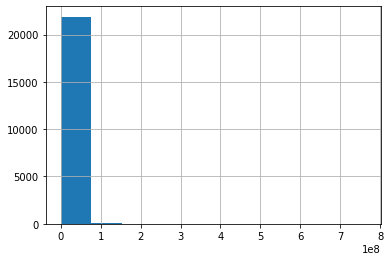

In [50]:
data.last_price.hist()

In [51]:
# посмотрим на слишком высокие цены
data.query('last_price > 100000000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1300,14,120000000.0,280.0,2018-07-12,5,4.70,4,162.000,3,False,...,30.00,0,Санкт-Петербург,24680.0,4247.0,1.0,464.0,3.0,339.0,225.0
1436,19,330000000.0,190.0,2018-04-04,3,3.50,7,95.000,5,False,...,40.00,0,Санкт-Петербург,23011.0,1197.0,3.0,519.0,3.0,285.0,233.0
1928,11,125000000.0,224.5,2017-01-24,4,2.65,4,163.500,3,False,...,30.00,1,Санкт-Петербург,22805.0,2335.0,0.0,NaN,2.0,497.0,174.0
2243,9,130278280.0,304.0,2015-07-24,5,3.11,9,91.785,7,False,...,15.05,0,Санкт-Петербург,25593.0,5913.0,2.0,164.0,0.0,NaN,599.0
2536,16,159984000.0,242.4,2015-08-27,4,3.85,9,131.000,7,False,...,20.00,0,Санкт-Петербург,21946.0,2242.0,1.0,679.0,1.0,227.0,501.0
3117,19,140000000.0,631.0,2019-03-30,7,2.65,5,145.000,5,False,...,60.00,0,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
5893,3,230000000.0,500.0,2017-05-31,6,2.65,7,123.900,7,False,...,40.00,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,50.0
7857,11,150000000.0,230.0,2017-10-25,8,2.65,8,220.000,8,False,...,25.00,0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,135.0
8900,13,190870000.0,268.0,2016-03-25,3,2.65,8,132.000,7,False,...,40.00,0,Санкт-Петербург,32440.0,5297.0,0.0,NaN,2.0,198.0,901.0
12674,16,140000000.0,241.0,2015-07-24,5,3.00,5,91.785,4,False,...,15.05,0,Санкт-Петербург,23512.0,3503.0,3.0,413.0,3.0,83.0,399.0


Видим, что есть очень дорогие квартиры, но их количество незначительно. Все они достаточно близко к центру города и большие по площади, что объясняет высокую цену. Однако эти выбросы могут повлиять на дальнейший анализ. Да и судя по площади некоторых квартир, не исключено, что могут быть ошибки в цене.

Лучше удалить их, так как таких квартир не много. 

In [52]:
data = data.query('last_price < 100000000')

<AxesSubplot:>

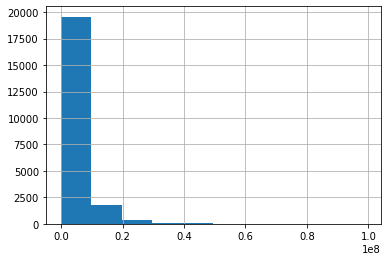

In [53]:
data.last_price.hist()

Видим, что значения цены более 20млн также очень редки. Удалим их тоже из данных.

In [54]:
data = data.query('last_price < 20000000')

<AxesSubplot:>

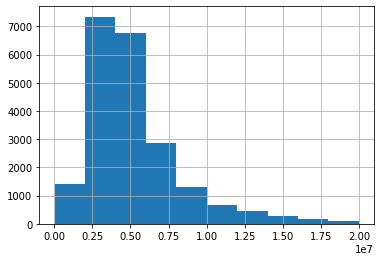

In [55]:
data.last_price.hist()

In [56]:
# отфильтруем данные с минимальными значениями цены
data.query('last_price < 500000')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5698,7,450000.0,42.0,2017-07-31,2,2.65,1,23.0,1,False,...,5.8,0,городской посёлок Будогощь,NaN,NaN,NaN,NaN,NaN,NaN,233.0
6859,6,490000.0,40.0,2017-12-11,1,2.65,5,17.6,3,False,...,9.0,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,43.0
8793,7,12190.0,109.0,2019-03-20,2,2.75,25,32.0,25,False,...,40.5,0,Санкт-Петербург,36421.0,9176.0,1.0,805.0,0.0,NaN,8.0
9581,7,450000.0,43.4,2018-08-31,2,2.65,5,30.3,3,False,...,5.5,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,96.0
10782,3,490000.0,29.1,2016-05-05,1,2.50,5,17.0,5,False,...,5.5,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,719.0
14911,5,430000.0,54.0,2018-06-26,2,2.65,3,30.5,3,False,...,8.8,0,посёлок станции Свирь,NaN,NaN,NaN,NaN,NaN,NaN,44.0
16032,8,480000.0,32.0,2019-01-06,1,2.65,2,16.0,1,False,...,9.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,83.0
16219,14,450000.0,38.5,2018-07-11,2,2.65,2,30.5,1,False,...,8.8,0,деревня Вахнова Кара,NaN,NaN,NaN,NaN,NaN,NaN,45.0
16274,18,440000.0,40.0,2018-07-10,1,2.65,5,17.6,1,False,...,9.0,0,деревня Старополье,NaN,NaN,NaN,NaN,NaN,NaN,45.0
17456,7,430000.0,30.4,2019-04-22,1,2.65,2,16.0,1,False,...,6.0,0,Сланцы,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Хоть цена в 400000 также является подозрительно дешевой, видим, что таких квартир несколько, они находятся в деревнях и посёлках. Возможно это комнаты в общежитиях. 

При этом есть выброс в 12000, что для такой площади квартиры не реально.

In [57]:
# проверим среднее значение цены для квартир площадью 100-115м
data.query('total_area > 100 and total_area < 115')['last_price'].median()

11100000.0

In [58]:
# исправим значение цены для этой квартиры
data.loc[data['last_price'] == 12190, 'last_price'] = 12190000

In [59]:
# проверим, изменилось ли значение
data.loc[8793]

total_images                              7
last_price                       12190000.0
total_area                            109.0
first_day_exposition    2019-03-20 00:00:00
rooms                                     2
ceiling_height                         2.75
floors_total                             25
living_area                            32.0
floor                                    25
is_apartment                          False
studio                                False
open_plan                             False
kitchen_area                           40.5
balcony                                   0
locality_name               Санкт-Петербург
airports_nearest                    36421.0
cityCenters_nearest                  9176.0
parks_around3000                        1.0
parks_nearest                         805.0
ponds_around3000                        0.0
ponds_nearest                           NaN
days_exposition                         8.0
Name: 8793, dtype: object

Проверим значения столбца `total_area`.

<AxesSubplot:>

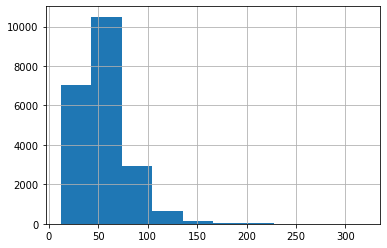

In [60]:
data.total_area.hist()

In [61]:
# Удалим значения больше 200м, так как они очень редко встречаются
data = data.query('total_area < 200')

<AxesSubplot:>

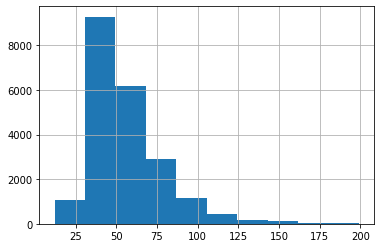

In [62]:
data.total_area.hist()

Столбец `first_day_exposition` в норме.

<AxesSubplot:>

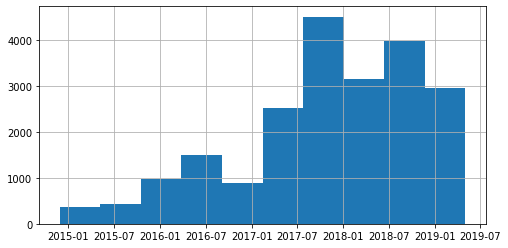

In [63]:
data.first_day_exposition.hist(figsize=(8,4))

В столбце `rooms` видим, очень редкие значения с количеством комнат больше 8. Можем их удалить.

<AxesSubplot:>

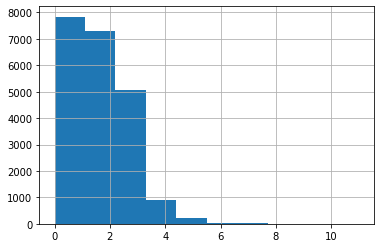

In [64]:
data.rooms.hist()

In [65]:
data = data.query('rooms < 8')

<AxesSubplot:>

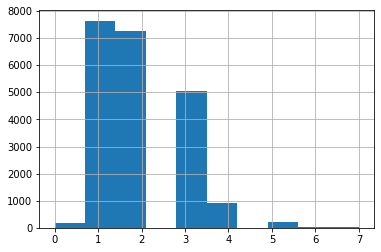

In [66]:
data.rooms.hist()

В столбце `floors_total` можем удалить дома выше, чем 40 этажей

<AxesSubplot:>

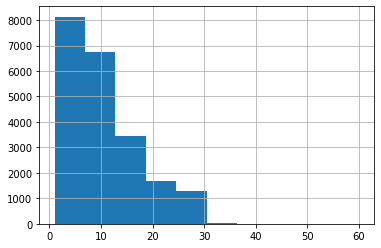

In [67]:
data.floors_total.hist()

In [68]:
# по этому графику видим, что значения больше 30 также можем удалить
data = data.query('floors_total < 30')

<AxesSubplot:>

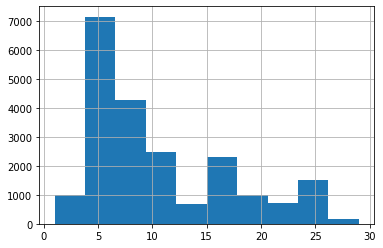

In [69]:
data.floors_total.hist()

Столбцы `floor`, `balcony` в порядке.

<AxesSubplot:>

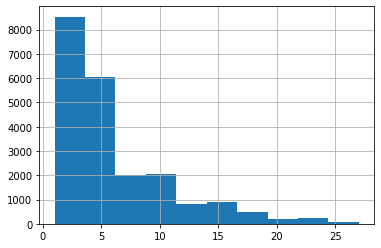

In [70]:
data.floor.hist()

In [71]:
data.balcony.unique()

array([2, 0, 1, 5, 4, 3])

Максимальное и максимальное значения стоблца `ceiling_height` выглядят странно.

In [72]:
data.ceiling_height.describe()

count    21305.000000
mean         2.711850
std          1.006368
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [73]:
# посмотрим на срез необычно больших значений
data.query('ceiling_height > 10')['ceiling_height'].unique()

array([ 25. ,  32. ,  27. ,  24. ,  26. ,  14. ,  20. ,  22.6,  27.5,
       100. ])

Скорее всего двузначные цифры представляют собой ошибочные данные. Заменим их на более реальные. Оставим максимальную высоту в 14м, так как это более вероятно, чем высота в 1.4м (ниже человеческого роста).

In [74]:
data['ceiling_height'] = data['ceiling_height'].replace(25, 2.5)
data['ceiling_height'] = data['ceiling_height'].replace(32, 3.2)
data['ceiling_height'] = data['ceiling_height'].replace(27, 2.7)
data['ceiling_height'] = data['ceiling_height'].replace(24, 2.4)
data['ceiling_height'] = data['ceiling_height'].replace(26, 2.6)
data['ceiling_height'] = data['ceiling_height'].replace(20, 2)
data['ceiling_height'] = data['ceiling_height'].replace(22.6, 2.26)
data['ceiling_height'] = data['ceiling_height'].replace(27.5, 2.75)
data['ceiling_height'] = data['ceiling_height'].replace(100, 10)

In [75]:
# проверим, заменились ли значения
data.query('ceiling_height > 10')['ceiling_height'].unique()

array([14.])

In [76]:
# проверим значения меньше 2м
data.query('ceiling_height < 2')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5712,5,1500000.0,42.8,2017-08-14,2,1.2,2,27.5,1,False,...,5.2,0,посёлок городского типа Мга,NaN,NaN,NaN,NaN,NaN,NaN,248.0
22590,16,6000000.0,55.0,2018-10-31,2,1.0,12,32.4,7,False,...,10.0,0,Санкт-Петербург,33053.0,14217.0,2.0,293.0,2.0,289.0,13.0


Так как их всего 2, можем их удалить, потому что высота потолка в жилых помещениях не может быть ниже 2м.

In [77]:
data = data.query('ceiling_height > 2')

По столбцу `living_area` максимальная площадь не вызывает вопросов, вполне возможно, что есть квартиры такой площади. Однако минимальное значение в 2м смущает.

In [78]:
data.living_area.describe()

count    21291.000000
mean        31.907031
std         15.722322
min          2.000000
25%         18.000000
50%         30.000000
75%         41.000000
max        159.600000
Name: living_area, dtype: float64

In [79]:
# посмотрим на срез квартир с маленькой площадью
data.query('living_area < 6')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02,1,2.65,17,3.0,17,False,...,11.0,0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
17582,11,2680000.0,22.0,2018-08-11,0,2.65,25,5.0,8,False,...,0.0,2,Санкт-Петербург,22735.0,11618.0,1.0,835.0,1.0,652.0,70.0
21758,0,2330000.0,23.0,2018-01-01,0,2.65,24,2.0,22,False,...,0.0,0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
21943,15,6100000.0,77.6,2019-02-28,4,2.50,9,5.4,1,False,...,9.8,0,Санкт-Петербург,29338.0,11270.0,1.0,584.0,0.0,NaN,33.0


Удалим значения меньше 6м, так как площадь жилой комнаты не может быть меньше 5м, а значение в 5.4 в помещении более 75м выглядит нереально.

In [80]:
data = data.query('living_area > 6')

<AxesSubplot:>

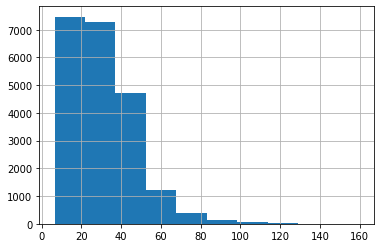

In [81]:
data.living_area.hist()

В столбце `kitchen_area` очень редки площади более 30м. Отфильтруем эти значения.

<AxesSubplot:>

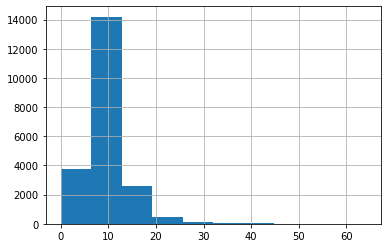

In [82]:
data.kitchen_area.hist()

<AxesSubplot:>

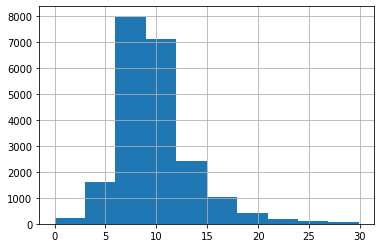

In [83]:
data = data.query('kitchen_area < 30')
data.kitchen_area.hist()

Столбцы `parks_around3000`, `ponds_around3000` вопросов не вызывают.

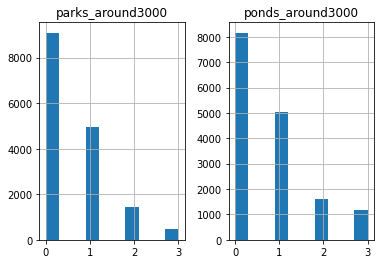

In [84]:
data[['parks_around3000', 'ponds_around3000']].hist();

В столбцах `airports_nearest`, `cityCenters_nearest`, `parks_nearest`, `ponds_nearest` мы ранее обнаружили ошибки в подгрузке данных. Много значений пропущено, при этом все они вполне реальны, поэтому оставим столбцы без изменений.

По столбцу `days_exposition` можем удалить значения более 1000 дней, потому что они очень редко встречаются

<AxesSubplot:>

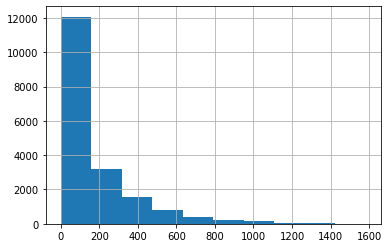

In [85]:
data.days_exposition.hist()

<AxesSubplot:>

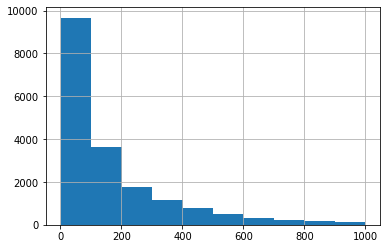

In [86]:
data = data.query('days_exposition < 1000')
data.days_exposition.hist()

**Вывод:** 

Во время предобработки данных были замечены и обработаны пропущенные значения в следующих столбцах:

    - ceiling_height - пропуски заполнены медианным значением по столбцу ceiling_height
    - floors_total - пропуски заполнены значанием указанного этажа квартиры + 2
    - living_area - пропуски заполнены медианным значением для каждой группы (по числу комнат)
    - is_apartment - пропуски заполнены 0 (False)
    - kitchen_area - пропуски заполнены медианным значением для каждой группы (по числу комнат), для студий нулем.
    - balcony - пропуски заполнены 0 
    - locality_name - пропуски заменены на "Ленинградская область"
    - airports_nearest - оставили значение nan
    - cityCenters_nearest - оставили значение nan
    - parks_around3000 - оставили значение nan
    - parks_nearest - оставили значение nan
    - ponds_around3000 - оставили значение nan
    - ponds_nearest - оставили значение nan
    - days_exposition - оставили значение nan
    
   Были удалены дублированные значения населенных пунков, устранены редкие и выбивающиеся значения (аномалии) в столбцах:
   
    - total_images (удалены значения > 20)
    - last_price (удалены значения > 20 млн; исправлено значение 12190 на 12190000)
    - total_area (удалены значения > 200 м2)
    - rooms (удалены значения > 8)
    - floors_total (удалены значения > 30)
    - ceiling_height (исправлены значения > 14 м и удалены < 2 м)
    - living_area (удалены значения < 6)
    - kitchen_area (удалены значения > 30)
    - days_exposition (удалены значения > 1000)

### Добавим дополнительную информацию к данным

In [87]:
# цена одного квадратного метра
data['price_per_square_meter'] = (data['last_price'] / data['total_area']).round(2)

In [88]:
# день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
data['weekday_of_publication'] = data['first_day_exposition'].dt.weekday

In [89]:
# месяц публикации объявления
data['month_of_publication'] = data['first_day_exposition'].dt.month

In [90]:
# год публикации объявления
data['year_of_publication'] = data['first_day_exposition'].dt.year

In [91]:
# тип этажа квартиры (значения — «первый», «последний», «другой»)
def categorize_floor(floor, floor_total):
    if floor == floor_total:
        return 'последний'
    if floor == 1:
        return 'первый'
    if floor > floor_total:
        return 'ошибка'
    return 'другой'

data['floor_type'] = data.apply(lambda x: categorize_floor(x['floor'], x['floors_total']), axis=1)

In [92]:
# расстояние до центра города в километрах
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0)

In [93]:
# проверим наличие новых колонок
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_of_publication,month_of_publication,year_of_publication,floor_type,cityCenters_nearest_km
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,NaN,0.0,NaN,81.0,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,90.0,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0
5,10,2890000.0,30.4,2018-09-10,1,2.65,12,14.4,5,False,...,NaN,NaN,NaN,55.0,95065.79,0,9,2018,другой,NaN
6,6,3700000.0,37.3,2017-11-02,1,2.65,26,10.6,6,False,...,NaN,0.0,NaN,155.0,99195.71,3,11,2017,другой,19.0
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,NaN,0.0,NaN,289.0,88524.59,6,2,2017,другой,15.0


### Проведем исследовательский анализ данных

#### Изучим параметры объектов.

<AxesSubplot:>

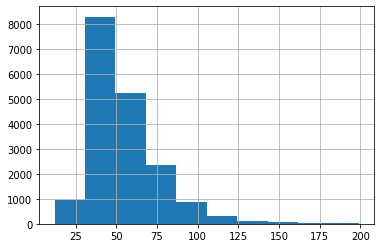

In [94]:
data.total_area.hist()

В столбце `total_area` видим, что больше всего квартир с площадью примерно от 30 до 85 м2.

<AxesSubplot:>

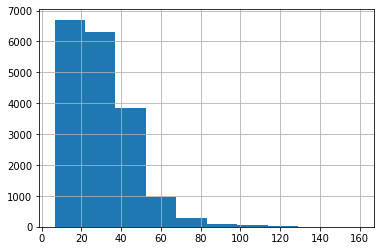

In [95]:
data.living_area.hist()

В столбце `living_area` значения намного меньше, что логично. Больше всего квартир с жилой площадью примерно от 10 до 60 м2. 

Маленькая площадь может объясняться наличием студий и небольших по площади квартир. Они чаще приобретаются, так как более дешевые.

Text(0, 0.5, 'количество квартир')

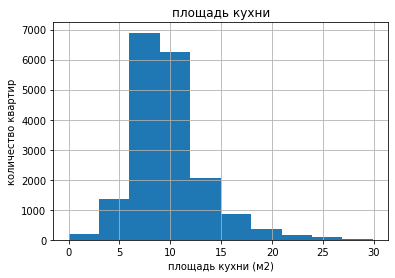

In [96]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
data.kitchen_area.hist()
plt.title('площадь кухни')
ax.set_xlabel('площадь кухни (м2)')
ax.set_ylabel('количество квартир')

В столбце `kitchen_area` основная масса значениий расположились в диапазоне от 5 до 15 м2.

<AxesSubplot:>

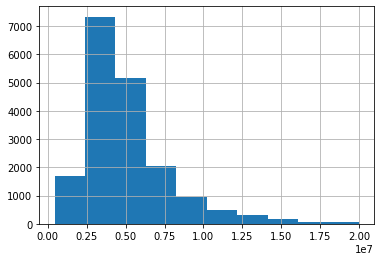

In [97]:
data.last_price.hist()

Столбец `last_price` показывает, что больше всего квартир было продано с диапазоном цены 2.5 - 7.5 млн.

<AxesSubplot:>

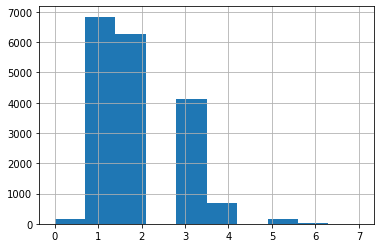

In [98]:
data.rooms.hist()

В столбце `rooms` видим, что больше всего квартир было продано с количеством комнат 1 и 2.

<AxesSubplot:>

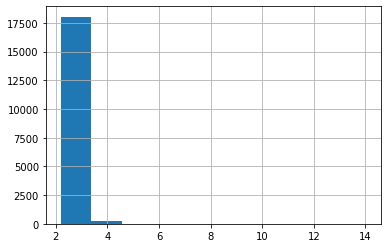

In [99]:
data.ceiling_height.hist()

В столбце `ceiling_height` видим, что высота потолка стандартно находится в диапазоне от 2 до 4 метров и очень редко превышает это значение, возможно для больших, двухэтажных квартир.

<AxesSubplot:>

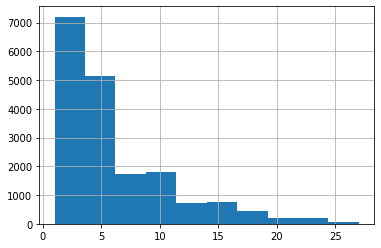

In [100]:
data.floor.hist()

Столбец `floor` показывает, что больше всего квартир было продано на низких этажах (до 5).

<AxesSubplot:>

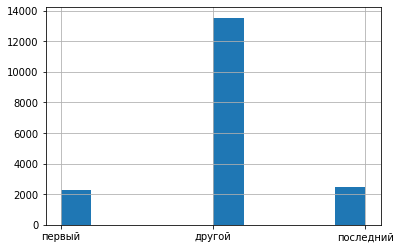

In [101]:
data.floor_type.hist()

В столбце `floor_type` видим, что люди чаще покупают квартиры не на первом и не на последнем этаже, что логично. Обычно эти этажи даже стоят дешевле, потому что продаются хуже.

<AxesSubplot:>

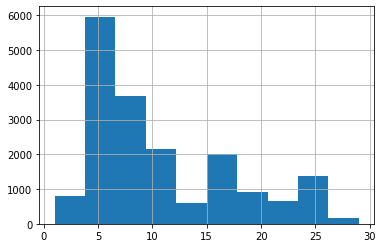

In [102]:
data.floors_total.hist()

<AxesSubplot:>

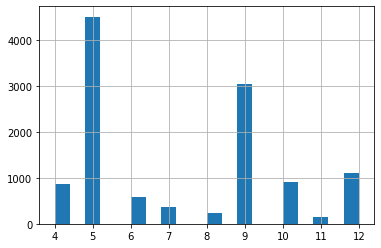

In [103]:
data.floors_total.hist(bins=20, range=(4,12))

В столбце `floors_total` видим, что больше всего квартир было продано в домах высотой от 5 до 10 этажей. Возможно, это вторичное жильё (потому что новостройки обычно высокие), либо жильё в деревнях и селах. Это тоже логично, эти виды жилья дешевле.

<AxesSubplot:>

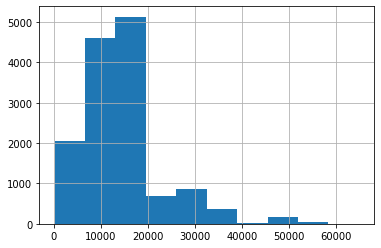

In [104]:
data.cityCenters_nearest.hist()

В столбце `cityCenters_nearest` видим, что люди чаще покупают квартиры недалеко от центра, но не совсем близко к нему, в радиусе примерно 10-20 км. Возможно потому, что в самом центре не так много квартир, а новые дома строят редко.

<AxesSubplot:>

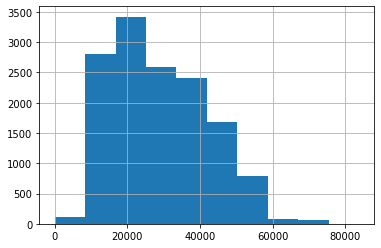

In [105]:
data.airports_nearest.hist()

По стобцу `airports_nearest` можно сказать, что больше квартир продается в среднеудаленном доступе к аэропорту (около 20 км). Совсем близкое расстояние популярностью не пользуется по известным причинам (шум).

<AxesSubplot:>

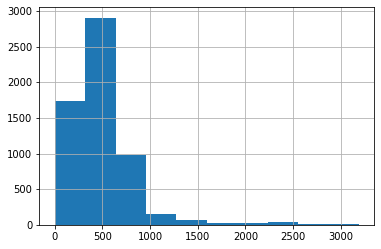

In [106]:
data.parks_nearest.hist()

В столбце `parks_nearest` видим, что большинство людей предпочитает квартиры ближе к паркам.

<AxesSubplot:>

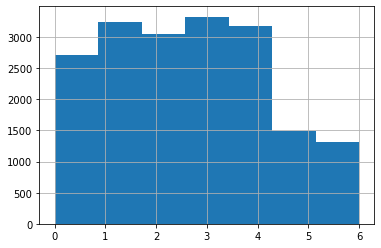

In [107]:
data.weekday_of_publication.hist(bins=7)

Столбец `weekday_of_publication` говорит о том, что люди чаще покупают квартиры будни, чем в выходные. Возможно, потому что больше свободного времени, а может потому что необходимые службы и банки также работают по будням.

<AxesSubplot:>

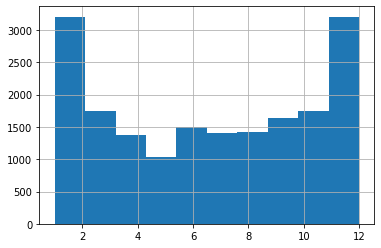

In [108]:
data.month_of_publication.hist()

В столбце `month_of_publication` видим, что больше всего продаж приходится на зимний период времени, а в середине года наблюдается спад.

#### Изучим информацию о том, как быстро продавались квартиры

Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление.
Постройте гистограмму.
Посчитайте среднее и медиану.
В ячейке типа markdown опишите, 

<AxesSubplot:>

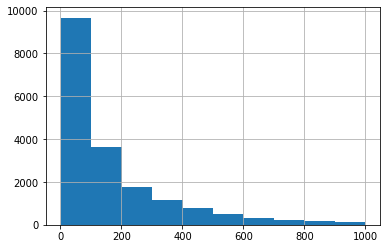

In [109]:
data.days_exposition.hist()

In [110]:
data.days_exposition.mean()

165.16384211677237

In [111]:
data.days_exposition.median()

91.0

In [112]:
data.days_exposition.describe()

count    18292.000000
mean       165.163842
std        185.742769
min          1.000000
25%         44.000000
50%         91.000000
75%        218.000000
max        999.000000
Name: days_exposition, dtype: float64

В среднем продажа квартиры занимает 90 дней (половина квартир была продана за это время). Можно считать быстрыми продажи менее чем за 40 дней (только 25% процентов квартир продается за это время). Долгими можно считать продажи более, чем за 200 дней.

Тут необходимо помнить, что также было удалено незначительное количество объявлений проданных более, чем за 1000 дней.

#### Посмотрим, какие факторы больше всего влияют на общую (полную) стоимость объекта.

Построим графики зависимости цены от:
- общей площади
- жилой площади
- площади кухни
- количества комнат
- этажа, на котором расположена квартира (первый, последний, другой)
- даты размещения (день недели, месяц, год)

0.7633550139057342


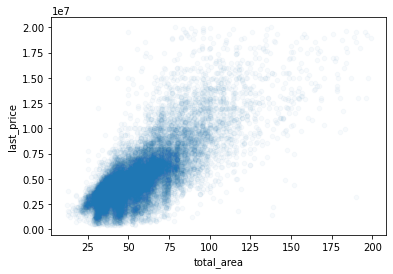

In [113]:
# построим диаграмму рассеяния и подсчитаем значение корреляции
data.plot(x='total_area', y='last_price', kind='scatter', alpha=0.03)
print(data['last_price'].corr(data['total_area']))

На графике зависимости цены от размеров общей площади видим, что есть положительная корреляция (чем больше площадь, тем больше цена объекта).

0.6410745383576969


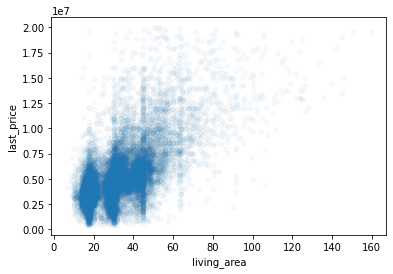

In [114]:
data.plot(x='living_area', y='last_price', kind='scatter', alpha=0.03)
print(data['last_price'].corr(data['living_area']))

На графике зависимости цены от размеров жилой площади видим, что в целом есть положительная корреляция (чем больше жилая площадь, тем больше цена объекта). Но также видим увеличение цены у небольших квартир с примерно одинаковой жилой площадью. Возможно, тут оказывает влияние третий фактор.

0.5194438518674673


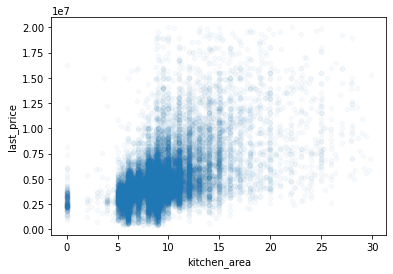

In [115]:
data.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.03)
print(data['last_price'].corr(data['kitchen_area']))

На графике зависимости цены от размеров площади кухни видим, что в целом есть положительная корреляция (чем больше площадь кухни, тем больше цена объекта), однако зависимость не такая сильная, как от общей площади и жилой площади.

0.5019510140595562


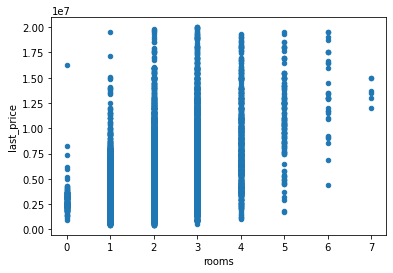

In [116]:
data.plot(x='rooms', y='last_price', kind='scatter')
print(data['last_price'].corr(data['rooms']))

<AxesSubplot:xlabel='rooms'>

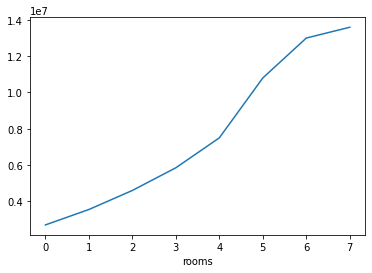

In [117]:
data.groupby('rooms')['last_price'].median().plot()

На графике зависимости цены от количества комнат в квартире видим, что в целом есть положительная корреляция (чем больше комнат, тем больше цена объекта), так как квартиры с большим количеством этажей имеют бОльшую стоимость. 

Однако квартиры со средним количеством комнат могут также иметь очень высокую цену. Скорее всего тут влияет также размер площади квартиры.

<AxesSubplot:xlabel='floor_type', ylabel='last_price'>

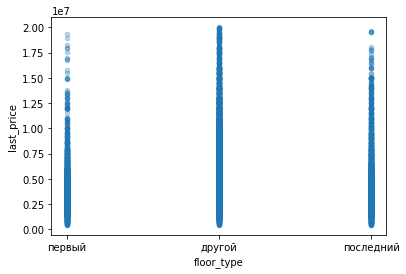

In [118]:
data.plot(x='floor_type', y='last_price', kind='scatter', alpha=0.3)

На графике зависимости цены от этажа видим, что цена выше чаще у квартир не на последнем и первом этажах, так как спрос на них меньше.

<AxesSubplot:xlabel='weekday_of_publication'>

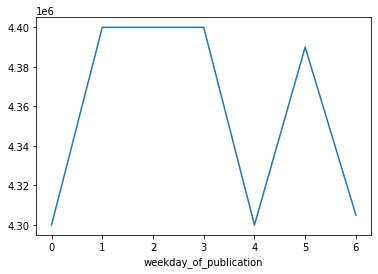

In [122]:
data.groupby('weekday_of_publication')['last_price'].median().plot()

<AxesSubplot:xlabel='month_of_publication'>

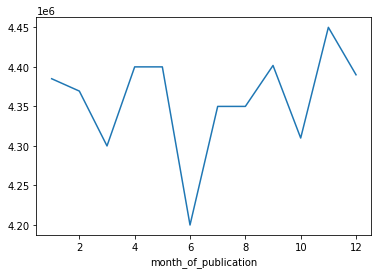

In [125]:
data.groupby('month_of_publication')['last_price'].median().plot()

<AxesSubplot:xlabel='year_of_publication'>

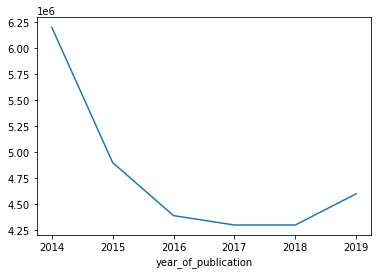

In [128]:
data.groupby('year_of_publication')['last_price'].median().plot()

На графиках зависимости цены от дня/месяца/года размещения объявления видим, что взаимосвязи между ценой и этими параметрами нет.

#### Найдем населенные пункты с самой высокой и самой низкой стоимостью квадратного метра.

In [131]:
data.groupby('locality_name')['locality_name'].count().sort_values(ascending=False).head(10)

locality_name
Санкт-Петербург      11896
посёлок Мурино         520
посёлок Шушары         388
Всеволожск             303
Колпино                295
посёлок Парголово      289
деревня Кудрово        274
Пушкин                 272
Гатчина                255
Выборг                 202
Name: locality_name, dtype: int64

In [132]:
localities_top10 = ['Санкт-Петербург', 'посёлок Мурино', 'посёлок Шушары', 'Всеволожск', 'Колпино', 'посёлок Парголово', 'деревня Кудрово', 'Пушкин', 'Гатчина', 'Выборг']
localities_top10_data = data.query('locality_name == @localities_top10')

localities_top10_data.pivot_table(index='locality_name', values='price_per_square_meter') \
                                  .sort_values(by='price_per_square_meter', ascending=False)

,price_per_square_meter
locality_name,
Санкт-Петербург,106169.385923
Пушкин,99865.556654
деревня Кудрово,92094.067080
посёлок Парголово,89138.920381
посёлок Мурино,85808.003538
посёлок Шушары,77719.793531
Колпино,74659.964441
Гатчина,67480.018078
Всеволожск,66978.159373


#### Найдем среднюю цену километра в Санкт-Петербурге и посмотрим, как стоимость зависит от расстояния до центра

In [133]:
# создадим отфильтрованный датафрейм, где:
#     - квартира находится в Санкт-Петербурге
#     - указано расстояние до центра города

SPB = data.query('locality_name == "Санкт-Петербург" and not cityCenters_nearest_km.isna()')
SPB.shape

(11880, 28)

In [134]:
# подсчитаем цену за км
SPB['price_per_km'] = (SPB['last_price'] / SPB['cityCenters_nearest_km']).round(2)
SPB.head()

/tmp/ipykernel_31/3125588902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  SPB['price_per_km'] = (SPB['last_price'] / SPB['cityCenters_nearest_km']).round(2)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_per_square_meter,weekday_of_publication,month_of_publication,year_of_publication,floor_type,cityCenters_nearest_km,price_per_km
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,2.0,574.0,558.0,92785.71,3,8,2015,другой,14.0,371142.86
9,18,5400000.0,61.0,2017-02-26,3,2.50,9,43.6,7,False,...,0.0,NaN,289.0,88524.59,6,2,2017,другой,15.0,360000.00
10,5,5050000.0,39.6,2017-11-16,1,2.67,12,20.3,3,False,...,2.0,553.0,137.0,127525.25,3,11,2017,другой,14.0,360714.29
15,16,4650000.0,39.0,2017-11-18,1,2.65,14,20.5,5,False,...,1.0,296.0,19.0,119230.77,5,11,2017,другой,14.0,332142.86
16,11,6700000.0,82.0,2017-11-23,3,3.05,5,55.6,1,False,...,0.0,NaN,397.0,81707.32,3,11,2017,первый,11.0,609090.91


<AxesSubplot:xlabel='cityCenters_nearest_km'>

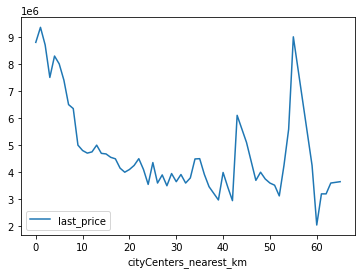

In [139]:
data.pivot_table(index='cityCenters_nearest_km', values='last_price', aggfunc='median').plot()

По графику отчетливо видно, что дороже стоят квартиры ближе к центру (км стоит дороже).

### Общий вывод

**1. Был изучен архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет.**


**2. При изучении данных были замечены и обработаны пропущенные значения в следующих столбцах:**

    - ceiling_height - пропуски заполнены медианным значением по столбцу ceiling_height
    - floors_total - пропуски заполнены значанием указанного этажа квартиры + 2
    - living_area - пропуски заполнены медианным значением для каждой группы (по числу комнат)
    - is_apartment - пропуски заполнены 0 (False)
    - kitchen_area - пропуски заполнены медианным значением для каждой группы (по числу комнат), для студий нулем.
    - balcony - пропуски заполнены 0 
    - locality_name - пропуски заменены на "Ленинградская область"
    - airports_nearest - оставили значение nan
    - cityCenters_nearest - оставили значение nan
    - parks_around3000 - оставили значение nan
    - parks_nearest - оставили значение nan
    - ponds_around3000 - оставили значение nan
    - ponds_nearest - оставили значение nan
    - days_exposition - оставили значение nan
    
   Всегда нужно принимать во внимание, какие поля в форме, которую заполняют продавцы являются обязательными. Если поле обязательное, а значение не подтянулось, это может быть баг.
    
   Также были замечены и удалены дублированные значения населенных пунков.
   
   Были устранены редкие и выбивающиеся значения (аномалии) в столбцах:
   
    - total_images (удалены значения > 20)
    - last_price (удалены значения > 20 млн; исправлено значение 12190 на 12190000)
    - total_area (удалены значения > 200 м2)
    - rooms (удалены значения > 8)
    - floors_total (удалены значения > 30)
    - ceiling_height (исправлены значения > 14 м и удалены < 2 м)
    - living_area (удалены значения < 6)
    - kitchen_area (удалены значения > 30)
    - days_exposition (удалены значения > 1000)
    
    
**3. Были добавлены новые колонки со следующей информацией:**

    - цена одного квадратного метра
    - день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
    - месяц публикации объявления
    - год публикации объявления
    - тип этажа квартиры (значения — «первый», «последний», «другой»)
    - расстояние до центра города в километрах
    
**4. Провели исследовательский анализ данных, в результате которого были сделаны следующие выводы:**

    1. Больше всего квартир продается в будние дни и в зимний период времени.
    2. Пользуются спросом квартиры с парками в пешей доступности, не далеко от центра города и аэропорта.
    3. Чаще всего выбирают квартиры в малоэтажных домах, на низких этажах. При этом последний и первый этаж покупают реже.
    4. Большим спросом пользуются квартиры в ценовом диапазоне 2.5-7.5 млн, небольшой площади, с количеством комнат 1-2. Они дешевле стоят, поэтому более ходовые.
    5. Продажа в среднем происходит в течение 90 дней с момента публикации объявления.
    6. Цена квартиры зависит от размеров площади квартиры: общей, жилой, в меньшей степени кухонной.
    7. Также на стоиость квартиры влияет количество комнат в ней, однако скорее всего тут оказывает влияние и площадь квартиры тоже.
    8. Цена выше чаще у квартир не на последнем и первом этажах, так как спрос на них меньше.
    9. Цена квартиры не зависит от дня, месяца или года публикации объявления.
    10. Квартиры ближе к центру города в Санкт-Петербурге стоят дороже.
    
**Также были созданы два списка с 10 населенными пунктами с самой высокой ценой за квадратный метр, а также 10 населенных пунктов с самой низкой ценой (localities_top10_high_price и localities_top10_low_price)**
